# Tutorial: Getting Started with JAX for machine learning

### _JAX vs PyTorch_ - a Bad Framing for getting started

In this session, we'll explore the capabilities of JAX as a machine learning framework. A common starting point is to compare JAX with PyTorch, but it's not very helpful: PyTorch is an entire collection of packages for end-to-end ML model operationalisation, and JAX is.... not that.

So let's understand JAX on its own terms, and how with its extended tools it can make a great alternative for a machine learning system, especially in research science. To do this, we'll make the following, showing the potential and field around circular magnetic sources.

![Magnetic scalar potential and field around finite dipole sources](source-field.png)

The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\phi = -\nabla\sum_{i=1}^N \textcolor{lightgray}{ \underbrace{\overbrace{\frac{1}{2\pi |\mathbf{r}-\mathbf{r_i}|}}^{\text{Surface of 2D ball}}\overbrace{\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}}^{\text{dipole term}}}_{\text{scalar potential }\phi_i}}.$$ A realistic (non-pointlike) source will have, in two dimensions, the form $\mathbf{H}(\mathbf{r}) \propto -\nabla(\mathbf{m}\cdot\mathbf{r})$ inside the source, and by Gauss' Law $\mathbf{H} \sim \mathbf{H}_\odot$ outside it.

The detail of the potential is irrelvant for our tutorial---what is important is only the $-\nabla$ and $\sum$ operations: that is, **differentiation** and **vectorisation**.

## Differentiation

JAX tries to be very good at a very small number of things. The first one is numerical differentiation. What we're doing here is a non-trivial example: the potential function (light grey above; i.e. _irrelevant_) is implemented, and then **the field is computed as the (negative) gradient of the potential**, using `jax.grad`.

In [1]:
import jax
import jax.numpy as jnp


def _potential(m, r0, r, radius=1.0):
    """Dipole potential in two dimensions."""
    d = r - r0
    d_norm = jnp.linalg.norm(d)
    m_dot_r = jnp.dot(m, d)
    close_to_source = d_norm <= radius
    interior = m_dot_r / radius / (2 * jnp.pi * radius)
    exterior = m_dot_r / d_norm / (2 * jnp.pi * d_norm)
    return jnp.where(close_to_source, interior, exterior)

def _field(m, r0, r):
    """Dipole field in two dimensions."""
    return -jax.grad(_potential, argnums=2)(m, r0, r)

These method will give us the value for the potential (or field) at a _single_ location $\mathbf{r}$ around a _single_ source with parameters $\mathbf{m}$ and $\mathbf{r_0}$.

In [2]:
r0 = jnp.array([0.0, 0.0]) # Source location
m = jnp.array([1.0, 0.0]) # Dipole moment
r = jnp.array([2.0, 1.0]) # Location at which to evaluate the potential and field

print(_potential(m, r0, r))
print(_field(m, r0, r))

0.06366197
[0.01909859 0.02546479]


## Vectorisation

This is our basic building block. In practice we want to evaluate these methods many times: i) at all the spatial locations, ii) for all the magnetic sources (summing over this), and (e.g. if this were training data) also iii) over the batch/sample dimension.

JAX also promotes **vectorisation** as a way of rapidly applying a function to arrays of data. The concept of vectorisation is familiar from Numpy and by extension PyTorch tensors. However, JAX does *not* provide array-based methods; instead, we are expected to make vectorisation explicit and functions should be written to accept scalars (like the mathematical functions we would write down on a page), and vectorised with `jax.vmap`.

(For standard Numpy functions (e.g. `mean`, or anything numpy does), JAX _does_ provide a drop-in replacement for numpy as `jax.numpy`.)

In [3]:
def _total(fun, m, r0, r):
    """Aggregate the field or potential of all sources."""
    points = jax.vmap(fun, in_axes=(None, None, 0)) # Map over the spatial locations - n.b. the return value is a function!
    batch = jax.vmap(points, in_axes=(0, 0, None)) # Map over the batch dimension
    components = jax.vmap(batch, in_axes=(1, 1, None))(m, r0, r) # Map over the sources AND APPLY THE FUNCTION to arrays
    return jnp.sum(components, axis=0)

In [4]:
import jax.random as jr

def configure(n_samples, n_sources, lim=3, res=32, seed=0):
    """
    Configures samples of sources.

    Args:
        n_samples (int): Number of samples to generate.
        n_sources (int): Number of sources in each sample.
        lim (int, optional): Domain range, in units of source radius. Defaults to 3.
        res (int, optional): Resolution of the field grid. Defaults to 32.
        seed (int): Random number generator seed.
    """

    # Generate random source properties (locations and magnetisations)
    key = jr.PRNGKey(seed)
    r0key, mkey, rkey = jr.split(key, 3)
    r0 = (lim / 3) * jr.normal(shape=(n_samples, n_sources, 2), key=r0key)
    m = jr.normal(key=mkey, shape=(n_samples, n_sources, 2))

    # Generate a grid of points at which to evaluate the field and potential
    range = jnp.linspace(-lim, lim, res)
    x, y = jnp.meshgrid(range, range)
    grid = jnp.stack([x.flatten(), y.flatten()], axis=1)

    return {
        "sources": jnp.concatenate([m, r0], axis=-1),
        "grid": grid,
        "potential_grid": _total(_potential, m, r0, grid),
        "field_grid": _total(_field, m, r0, grid),
    }

In [11]:
config = {
    "n_samples": 1,
    "n_sources": 2,
    "seed": 43,
    "lim": 3,
    "res": 200,
}

%time data = configure(**config)

CPU times: user 207 ms, sys: 14.8 ms, total: 221 ms
Wall time: 223 ms


### Optional: JIT compilation

With vectorised operations, we will commonly wish to just-in-time compile the function being vectorised over, which we do with `jax.jit`. This will usually give a 3-4x speedup out-of-the-box. Not enough to be a drop-in replacement for Fortran or C++, but it works with GPUs and Apple Silicon without any further effort.

In [12]:
# This compiles down the stack, so e.g. potential (on which field depends) is compiled as well
_field = jax.jit(_field)

%time data = configure(**config)

CPU times: user 60.7 ms, sys: 3.09 ms, total: 63.8 ms
Wall time: 61 ms


In [9]:
# Plotting style setup
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "ieee"])

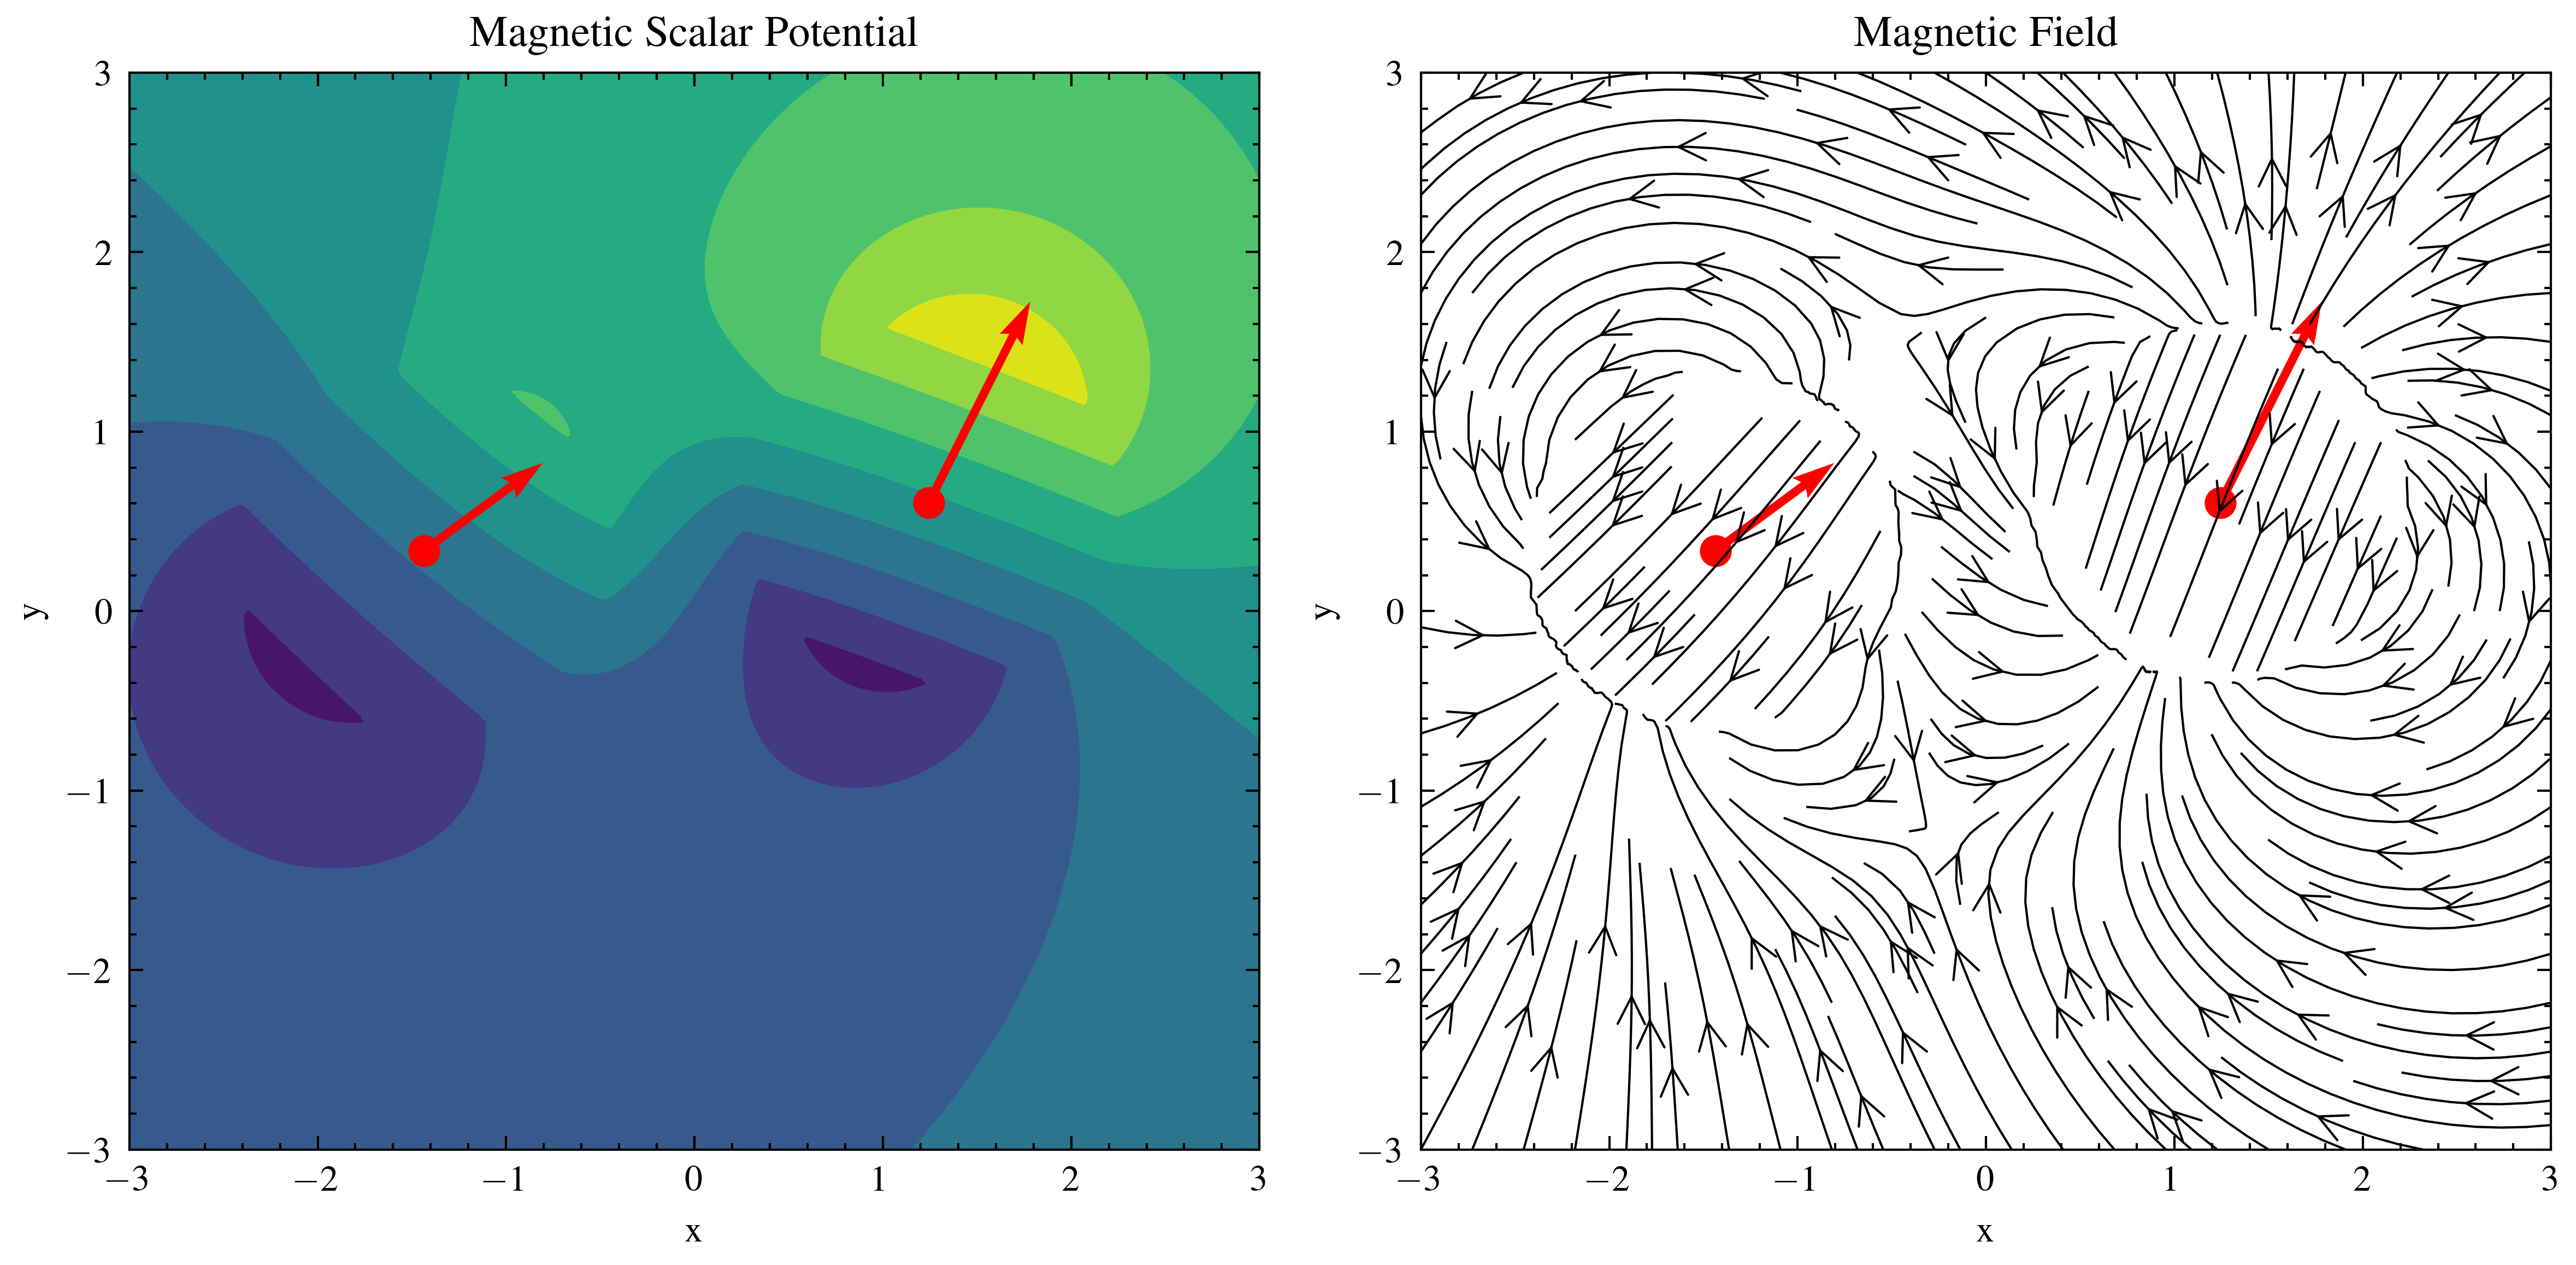

In [13]:
from hypermagnetics import plots

plots(data, model=None)

## Appendix reading material

### Key Differences between JAX and PyTorch

- **Functional Programming Paradigm**: JAX encourages a functional programming style, offering a different approach to state and side-effects compared to PyTorch.
- **First-Class Automatic Differentiation**: JAX extends autodiff capabilities beyond what's commonly found in PyTorch, particularly with respect to functional transformations.
- **XLA Backend**: Leveraging XLA (Accelerated Linear Algebra) allows JAX to optimize and execute computations across a wide range of hardware efficiently.

### Why Not a Direct Comparison?

- **Different Design Philosophies**: While PyTorch emphasizes an imperative style with a dynamic computation graph, JAX is rooted in functional programming and static computation graphs.
- **Complementary, Not Competitive**: JAX isn't necessarily a replacement for PyTorch. It can be used in conjunction with PyTorch, especially in areas where JAX's functional style and autodiff capabilities shine.
- **Focus on Strengths**: For newcomers, understanding JAX's strengths, such as its performance in large-scale, high-performance computing environments, is more beneficial than a direct comparison with PyTorch.

### How does JAX achieve its fast numerical differentiation through `jax.grad` and `jax.jit`?

JAX achieves its fast numerical differentiation through a combination of automatic differentiation (AD), just-in-time (JIT) compilation, and its underlying XLA (Accelerated Linear Algebra) backend.

1. **Automatic Differentiation (AD)**. JAX primarily uses reverse-mode AD, which is efficient for functions with many inputs and few outputs, a common scenario in machine learning. This is in contrast to forward-mode AD, which is more efficient for functions with few inputs and many outputs.
`jax.grad` transforms a function that computes an output given inputs into another function that computes the gradient of the output with respect to its inputs. This transformation leverages the chain rule of calculus in a way that is highly optimized for computational efficiency.

2. **Just-In-Time (JIT) Compilation**. When you apply jax.grad to a function for the first time with a set of inputs, JAX traces the function’s execution to capture the sequence of operations performed. This trace is then compiled into highly efficient machine code using XLA. During JIT compilation, optimizations are applied at the operation level (e.g., fusing operations together) and at the memory access level (e.g., minimizing memory reads and writes). These optimizations are crucial for achieving high performance, especially on GPU and TPU hardware.

3. **XLA Backend**. XLA, or Accelerated Linear Algebra, is a compiler that generates optimized machine code for linear algebra operations. It supports multiple hardware platforms, including CPUs, GPUs, and TPUs. This allows JAX to run efficiently across different computing environments. XLA takes advantage of hardware-specific features, such as SIMD (Single Instruction, Multiple Data) on CPUs or tensor cores on NVIDIA GPUs. These optimizations are critical for achieving high performance in numerical computations and differentiations.